[TODO] - citation

[TODO] - word count info



# NeurIPS historical conference data analysis

I was reading an old NIPS paper form 2005, and was unconsciously surprised that there's no appendix, so I suddenly got an urge to check when did appendices start becoming a 'trend'... and as I suspected it's almost a step function:

[PLOT]

Since I already had the data, I did some other statistical analysis of the conference data, check it out: [BLOG]

Thanks to the organisers of NeurIPS all the accepted paper data is neatly available on https://papers.nips.cc/

Unfortunately, there would be also many insights from rejected papers, but these are not available. The total number of submissions and acceptance rate is given in the press kit, but it's in PDF which is difficult to parse.



Most of the information was available for each paper from the main website, and I used some additional tools to get other info. the following is available:
- title
- year
- author names 
- suplementary material indicator (yes/no)
- [some] author affiliation
- [some] abstract
- [some] full paper text contents
- [some] reviews
- [TODO] number of citations (scraped from scholar)


---

In [621]:
import re
import pickle
import requests
import collections
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import gender_guesser.detector as gender
detector = gender.Detector()
import scipy.stats as stats
from bs4 import BeautifulSoup

In [622]:
with open('data/neurips_conf_data.pkl', 'rb') as handle:
    conf_data = pickle.load(handle)
    
total_authors = {}
total_institutions = {}
phd_authors = {}
year_stats = {}

year_stats['unique_authors_info'] = []
year_stats['unique_institutions_info'] = []

for kk, vals in conf_data.items():
    # Unique authors and institutions
    paper_info = {}
    author_papers = {}
    institution_papers = {}
    for paper in vals:
        # get yearly unique authors and papers per author
        for a_idx, a_name in enumerate(paper['authors']):
            ahash = '{} {}'.format(a_name['given_name'], a_name['family_name'])  # ahash = '{}_{}'.format(a_name['given_name'].upper(), a_name['family_name'].upper())
            if ahash in author_papers.keys():
                author_papers[ahash]['n_papers'].append((a_idx + 1, len(paper['authors'])))
            else:
                author_papers[ahash] = {}
                author_papers[ahash]['n_papers'] = [(a_idx + 1, len(paper['authors']))]
                author_papers[ahash]['gender'] = detector.get_gender(ahash.split()[0])
        # get yearly unique institutions and papers per institution
        for i_name in paper['institutions']:
            if i_name is None or i_name == '':
                continue
            if i_name in institution_papers.keys():
                institution_papers[i_name] += 1
            else:
                institution_papers[i_name] = 1
    # Update yearly author and institution info
    year_stats['unique_authors_info'].append(author_papers)
    year_stats['unique_institutions_info'].append(institution_papers)
    
    # Update total authors and institutions
    for t_author in author_papers.keys():
        if t_author in total_authors.keys():
            total_authors[t_author]['n_papers'].extend(author_papers[t_author]['n_papers'])
        else:
            total_authors[t_author] = {}
            total_authors[t_author]['n_papers'] = author_papers[t_author]['n_papers'].copy()
            total_authors[t_author]['gender'] = author_papers[t_author]['gender']
            
    for t_inst in institution_papers.keys():
        if t_inst in total_institutions.keys():
            total_institutions[t_inst] += institution_papers[t_inst]
        else:
            total_institutions[t_inst] = institution_papers[t_inst]
            
    # Update PhD author productivity
    for phd_auth in author_papers.keys():
        if phd_auth in phd_authors.keys():
            if int(kk) < phd_authors[phd_auth]['start_date'] + 5:
                phd_authors[phd_auth]['n_papers'].extend(author_papers[phd_auth]['n_papers'])
        else:
            phd_authors[phd_auth] = {}
            phd_authors[phd_auth]['start_date'] = int(kk)
            phd_authors[phd_auth]['n_papers'] = author_papers[phd_auth]['n_papers'].copy()
            phd_authors[phd_auth]['gender'] = author_papers[phd_auth]['gender']
    
    
# Sorting by number of papers
total_institutions_sorted = [{w: total_institutions[w]} for w in sorted(total_institutions, key=total_institutions.get, reverse=False) if w is not None and w != '']
total_authors_sorted = [{w: len(total_authors[w]['n_papers'])} for w in sorted(total_authors, key=lambda x: len(total_authors[x]['n_papers']), reverse=False)]


# PhD analysis
phd_start_year = {}
for kk, vv in phd_authors.items():
    if vv['start_date'] in phd_start_year.keys():
        phd_start_year[vv['start_date']].append(vv['n_papers'])
    else:
        phd_start_year[vv['start_date']] = [vv['n_papers']]
    

---

## Quantitative analysis

In this section let's visualise the basic information, such as:

- number of accepted papers (In the first conference instance in 1987 there was a total of 90 accepted papers, while in 2020 this number is 1898)


- total number of unique authors (conference openess)
- number of authors as a percentage of world population (perspective)
- total number of unique institutions (conference openess)


- percentage of single author papers
- average number of authors per paper (could be an indicator of paper complexity)
- average number of different institutions per paper (institutional collaboration)


- average number of papers per author
- average number of papers per institution

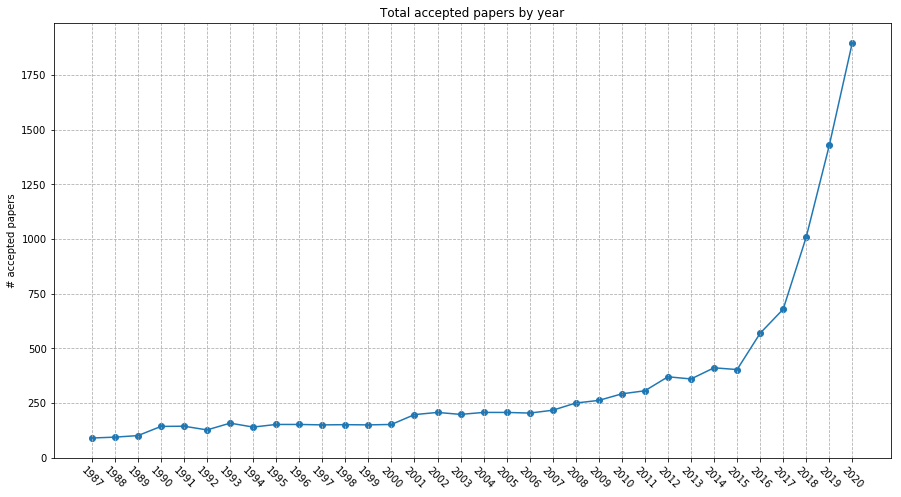

In [623]:
n_accepted = [len(conf_data[kk]) for kk in sorted(conf_data.keys())]
plt.scatter(np.arange(len(n_accepted)), n_accepted)
plt.plot(n_accepted)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total accepted papers by year')
plt.ylabel('# accepted papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--')
plt.show()

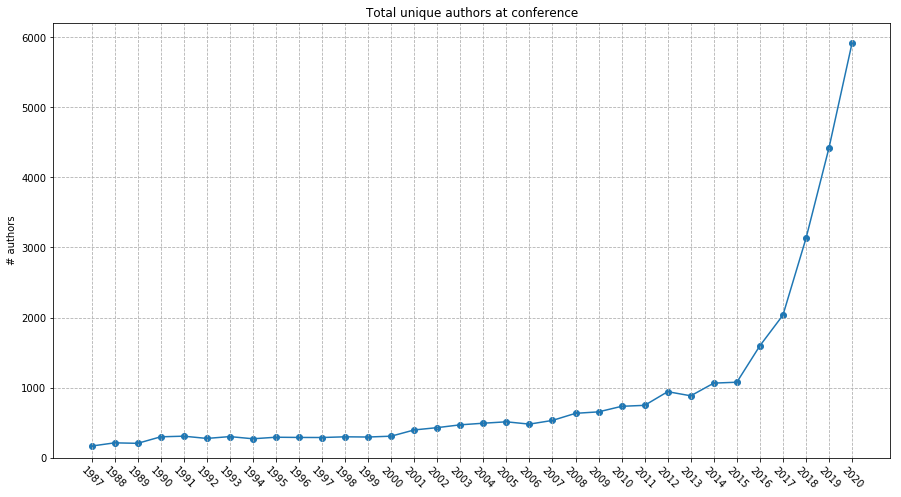

In [624]:
unique_authors = [len(ss) for ss in year_stats['unique_authors_info']]
plt.scatter(np.arange(len(unique_authors)), unique_authors)
plt.plot(unique_authors)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total unique authors at conference')
plt.ylabel('# authors')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--')
plt.show()

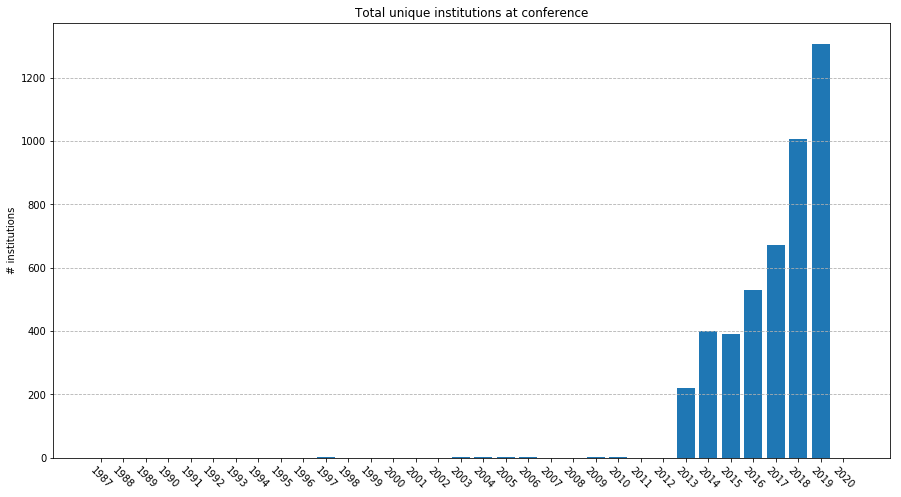

In [625]:
unique_institutions = [len(ss) for ss in year_stats['unique_institutions_info']]
plt.bar(np.arange(len(unique_institutions)), unique_institutions)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total unique institutions at conference')
plt.ylabel('# institutions')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
plt.show()

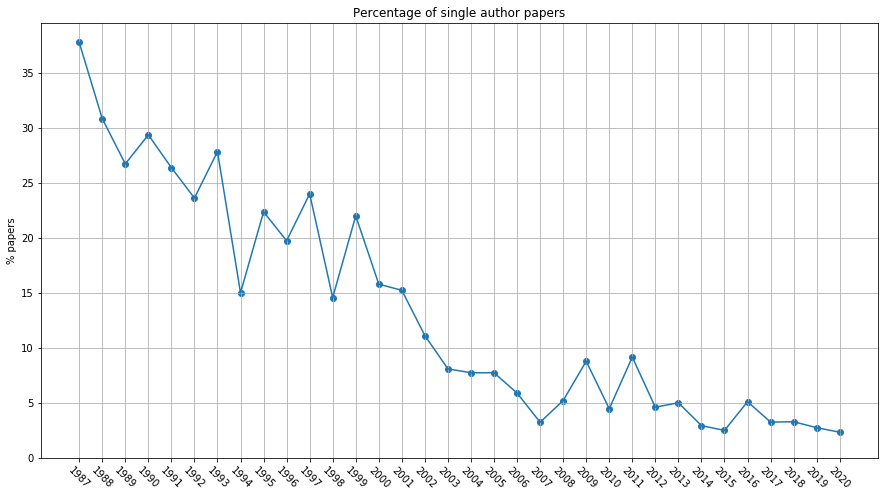

In [626]:
single_authors = 100 * np.array([np.mean([len(pp['authors'])==1 for pp in conf_data[kk]]) for kk in sorted(conf_data.keys())])
plt.scatter(np.arange(len(single_authors)), single_authors)
plt.plot(single_authors)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Percentage of single author papers')
plt.ylabel('% papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

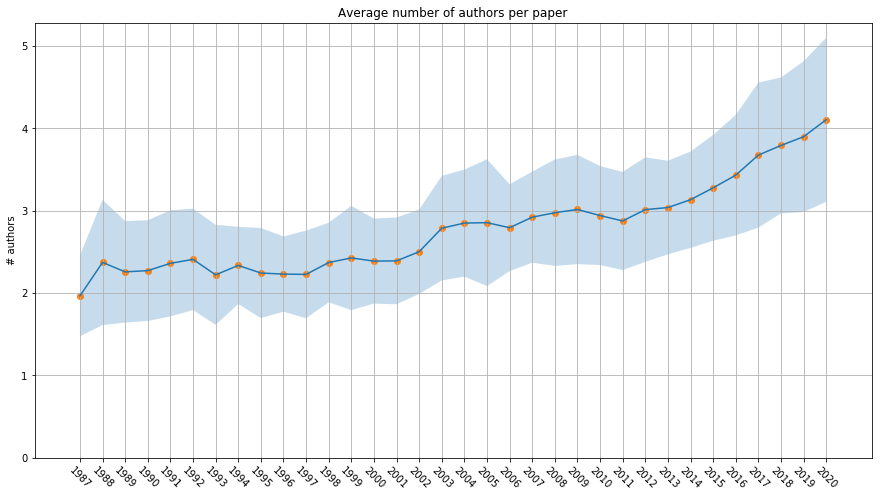

In [627]:
authors_per_paper_mean = np.array([np.mean([len(pp['authors']) for pp in conf_data[kk]]) for kk in sorted(conf_data.keys())])
authors_per_paper_std = np.array([np.std([len(pp['authors']) for pp in conf_data[kk]]) for kk in sorted(conf_data.keys())])
plt.plot(authors_per_paper_mean)
plt.fill_between(
    np.arange(len(conf_data)),
    authors_per_paper_mean - 0.5 * authors_per_paper_std,
    authors_per_paper_mean + 0.5 * authors_per_paper_std,
    alpha=0.25)
plt.scatter(np.arange(len(authors_per_paper_mean)), authors_per_paper_mean)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of authors per paper')
plt.ylabel('# authors')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


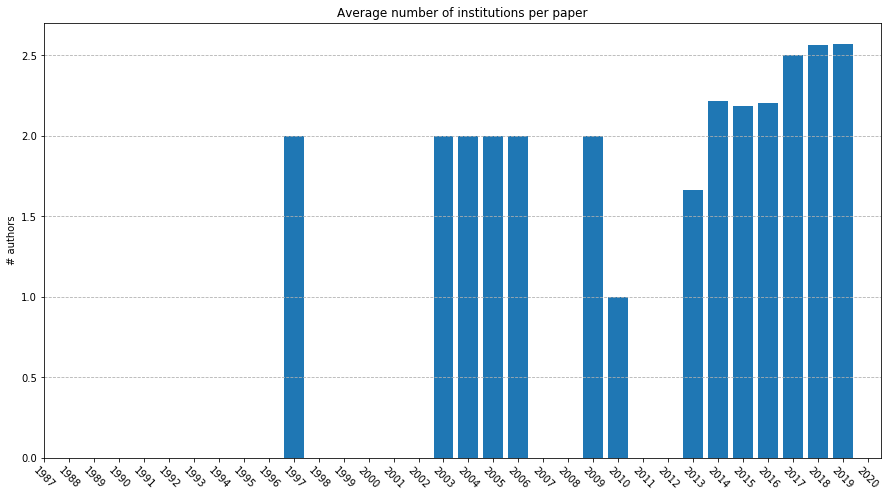

In [628]:
avg_institutions_per_paper = [np.mean([len(pp['institutions']) for pp in conf_data[kk] if len(pp['institutions']) and pp['institutions'][0] is not None and pp['institutions'][0] != '']) for kk in sorted(conf_data.keys())]
plt.bar(np.arange(len(avg_institutions_per_paper)), avg_institutions_per_paper)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of institutions per paper')
plt.ylabel('# authors')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
plt.show()

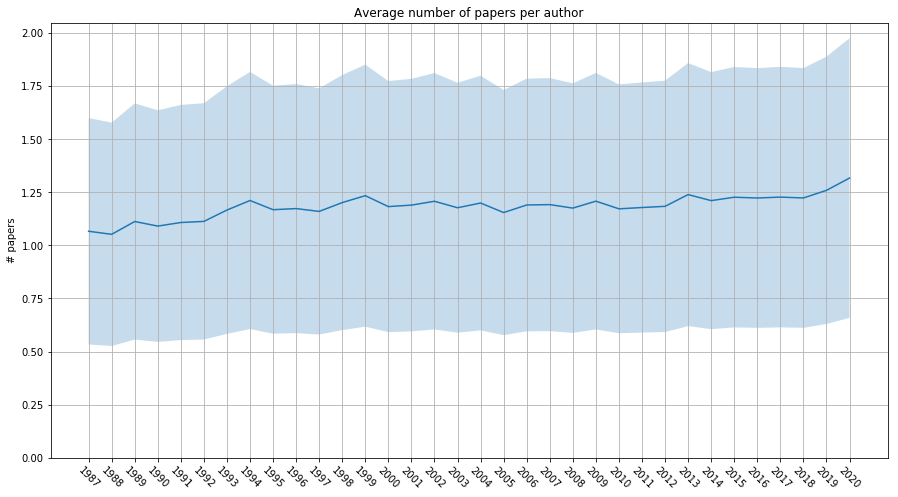

In [629]:
papers_per_author_mean = np.array([np.mean([len(vv['n_papers']) for vv in ss.values()]) for ss in year_stats['unique_authors_info']])
papers_per_author_std = np.array([np.mean([len(vv['n_papers']) for vv in ss.values()]) for ss in year_stats['unique_authors_info']])
plt.plot(papers_per_author_mean)
plt.fill_between(
    np.arange(len(conf_data)),
    papers_per_author_mean - 0.5 * papers_per_author_std,
    papers_per_author_mean + 0.5 * papers_per_author_std,
    alpha=0.25)

fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of papers per author')
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


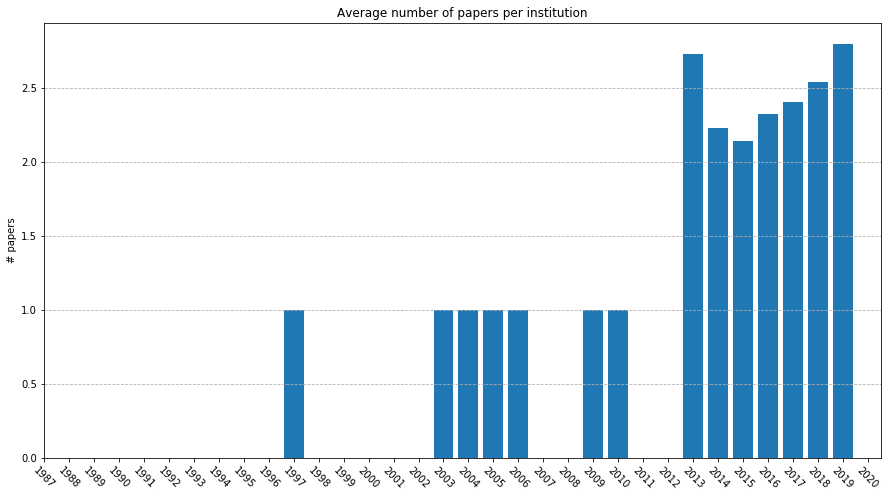

In [630]:
avg_papers_per_institution = [np.mean([vv for vv in ss.values()]) for ss in year_stats['unique_institutions_info']]
plt.bar(np.arange(len(avg_papers_per_institution)), avg_papers_per_institution)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of papers per institution')
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
plt.show()

## Qualitative analysis


Here I would like to investigate more 
- [TODO] average number of citations per paper (although this is biased as older papers have been around more)




/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


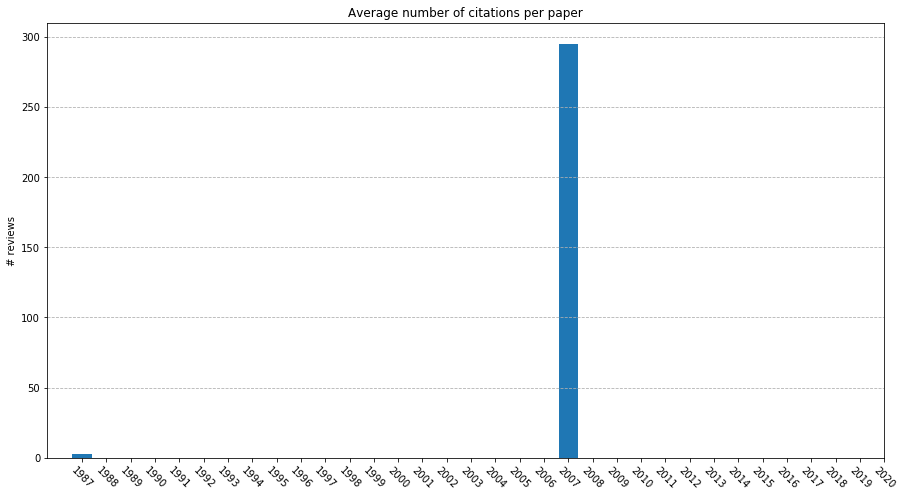

In [631]:
n_citations = [np.mean([vv['citations'] for vv in vals if vv['citations'] is not None]) for vals in conf_data.values()]
n_citations_std = [np.std([vv['citations'] for vv in vals if vv['citations'] is not None]) for vals in conf_data.values()]
plt.bar(np.arange(len(n_citations)), n_citations)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of citations per paper')
plt.ylabel('# reviews')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
plt.show()


Quality of reviews:
- number of reviews per paper
- average reviewer confidence
- average review length


/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


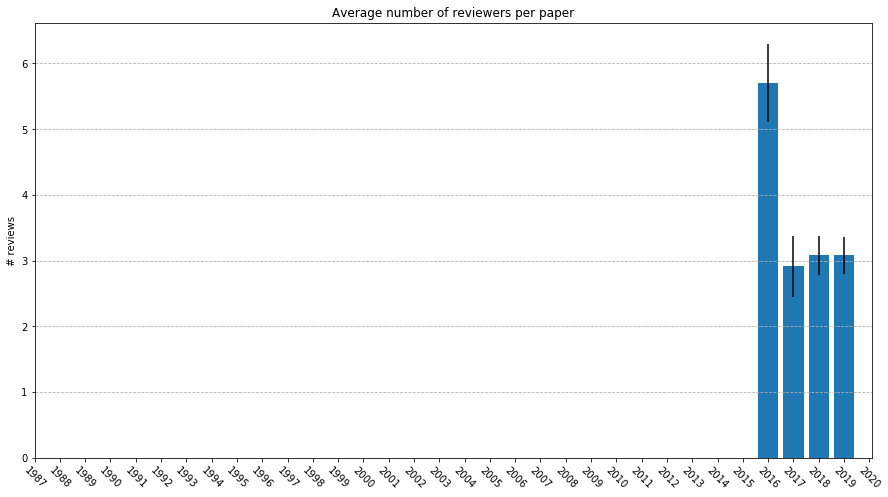

In [632]:
n_reviews = [np.mean([len(vv['reviews']) for vv in vals if vv['reviews'] is not None]) for vals in conf_data.values()]
n_reviews_std = [np.std([len(vv['reviews']) for vv in vals if vv['reviews'] is not None]) for vals in conf_data.values()]
plt.bar(np.arange(len(conf_data)), n_reviews, yerr=n_reviews_std)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average number of reviewers per paper')
plt.ylabel('# reviews')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
plt.show()

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


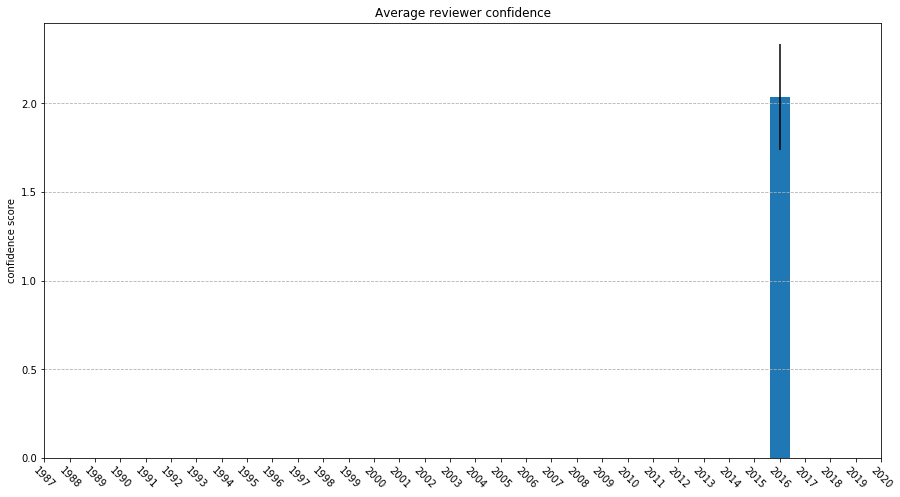

In [633]:
review_score = [np.mean([np.mean([rc['confidence'] for rc in vv['reviews'].values() if rc['confidence'] is not None]) for vv in vals if vv['reviews'] is not None]) for vals in conf_data.values()]
review_score_std = [np.std([np.mean([rc['confidence'] for rc in vv['reviews'].values() if rc['confidence'] is not None]) for vv in vals if vv['reviews'] is not None]) for vals in conf_data.values()]
plt.bar(np.arange(len(conf_data)), review_score, yerr=review_score_std)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average reviewer confidence')
plt.ylabel('confidence score')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
plt.show()

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


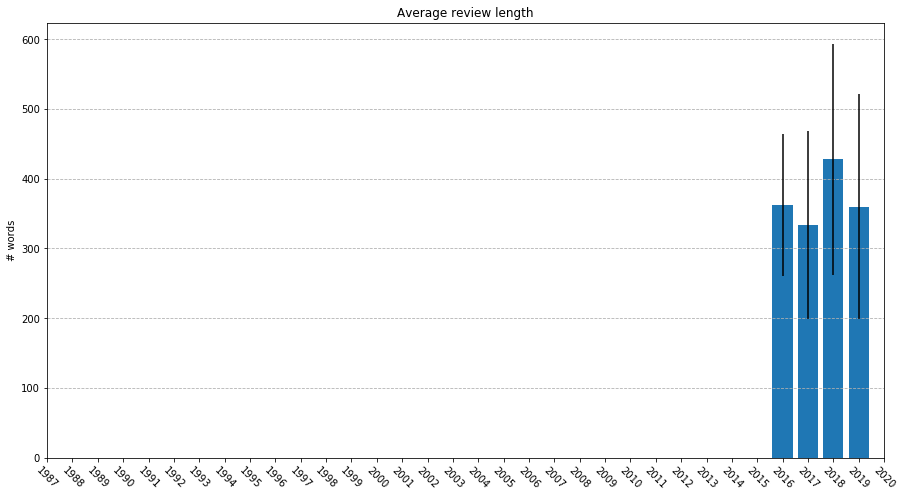

In [634]:
review_words = [np.mean([np.mean([len(rc['text'].split(' ')) for rc in vv['reviews'].values()]) for vv in vals if vv['reviews'] is not None]) for vals in conf_data.values()]
review_words_std = [np.std([np.mean([len(rc['text'].split(' ')) for rc in vv['reviews'].values()]) for vv in vals if vv['reviews'] is not None]) for vals in conf_data.values()]
plt.bar(np.arange(len(conf_data)), review_words, yerr=review_words_std)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average review length')
plt.ylabel('# words')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
plt.show()

Paper title:
- average title length
- percentage of papers containing an abbreviation (if there is at least one all-caps word in the title)
- "All you need" in the title

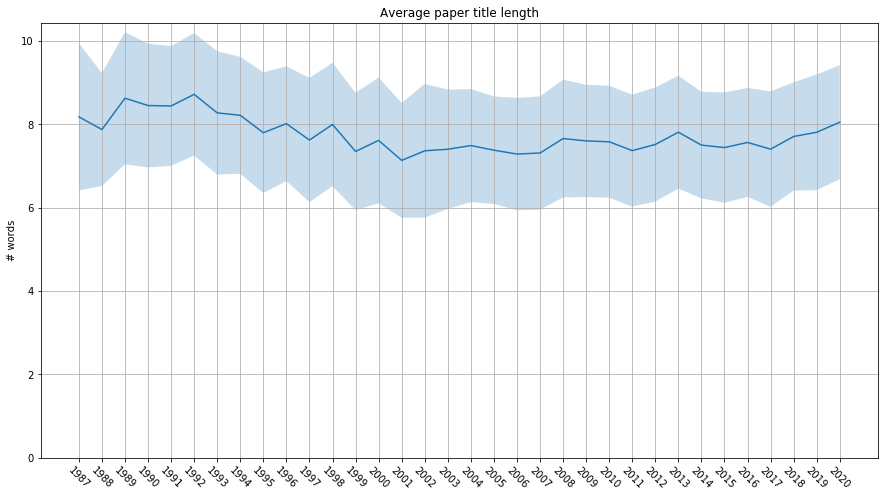

In [635]:
title_lenghts = np.array([np.mean([len(vv['title'].split(' ')) for vv in conf_data[kk]]) for kk in sorted(conf_data.keys())])
title_lenghts_std = np.array([np.std([len(vv['title'].split(' ')) for vv in conf_data[kk]]) for kk in sorted(conf_data.keys())])
plt.plot(title_lenghts)
plt.fill_between(
    np.arange(len(conf_data)),
    title_lenghts - 0.5 * title_lenghts_std,
    title_lenghts + 0.5 * title_lenghts_std,
    alpha=0.25)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average paper title length')
plt.ylabel('# words')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

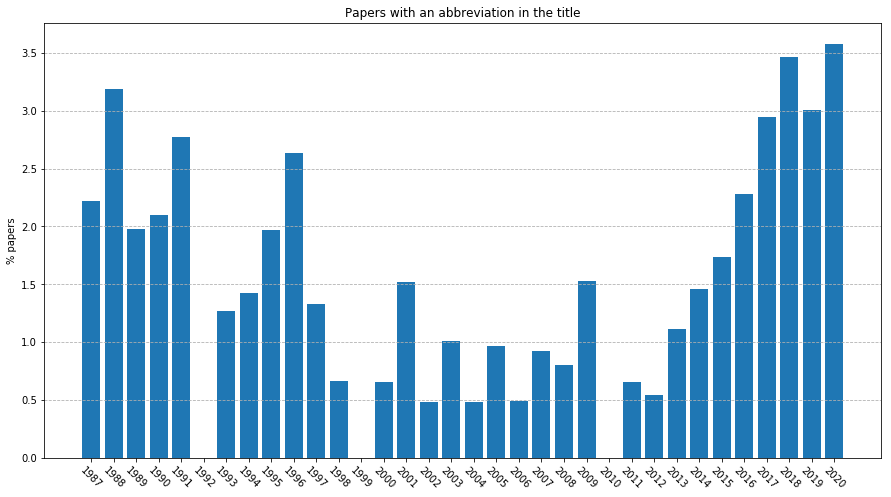

In [636]:
titles_abbreviations = [100 * np.mean([sum([ww.isupper() and ww[-1] == ':' for ww in vv['title'].split(' ')])
                                   for vv in conf_data[kk]])
                        for kk in sorted(conf_data.keys())]

plt.bar(np.arange(len(titles_abbreviations)), titles_abbreviations)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Papers with an abbreviation in the title')
plt.ylabel('% papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
plt.show()

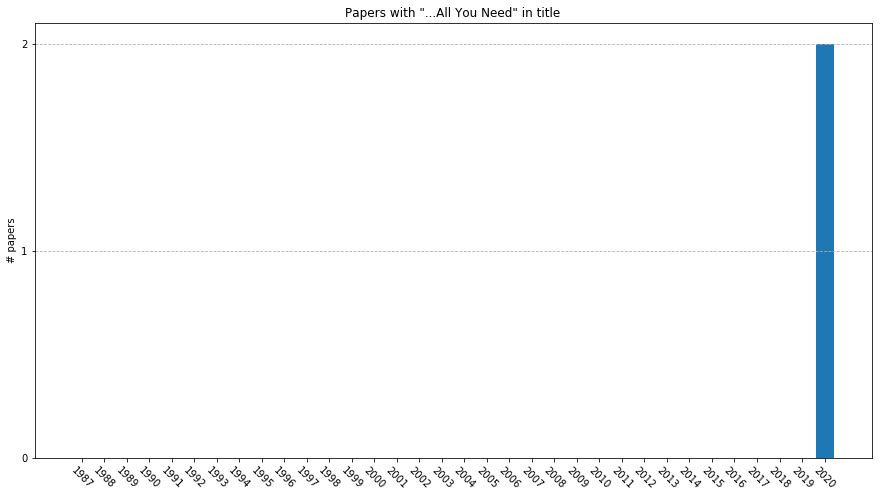

In [637]:
title_ayn = [sum([1 if 'All You Need' in vv['title'] or 'all you need' in vv['title'] else 0 for vv in conf_data[kk]]) for kk in sorted(conf_data.keys())]
plt.bar(np.arange(len(title_ayn)), title_ayn)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Papers with "...All You Need" in title')
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(linestyle='--', axis='y')
plt.show()

Paper Abstract:
- average abstract length
- average abstract word length
- average abstract word complexity

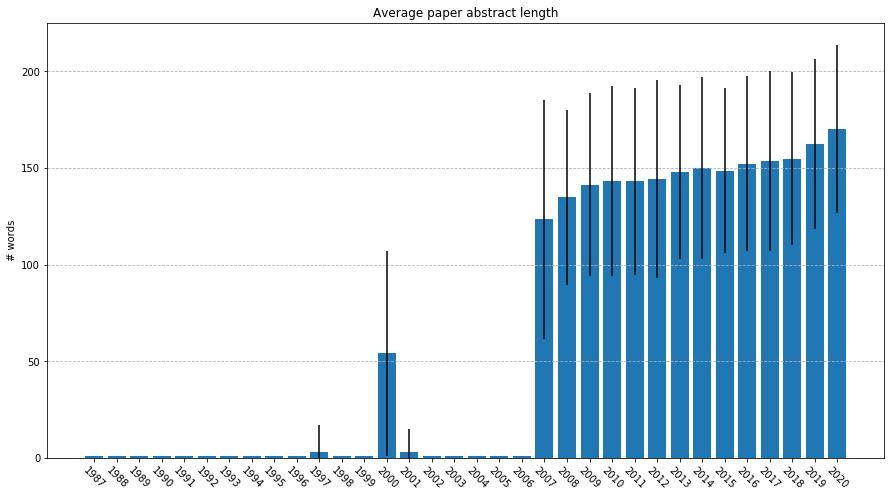

In [638]:
abstract_lenghts = np.array([np.mean([len(vv['abstract'].split(' ')) for vv in conf_data[kk] if vv['abstract'] is not None]) for kk in sorted(conf_data.keys())])
abstract_lenghts_std = np.array([np.std([len(vv['abstract'].split(' ')) for vv in conf_data[kk] if vv['abstract'] is not None]) for kk in sorted(conf_data.keys())])
plt.bar(np.arange(len(abstract_lenghts)), abstract_lenghts, yerr=abstract_lenghts_std)

#plt.plot(abstract_lenghts)
# plt.fill_between(
#     np.arange(len(conf_data)),
#     abstract_lenghts - 0.5 * abstract_lenghts_std,
#     abstract_lenghts + 0.5 * abstract_lenghts_std,
#     alpha=0.25)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average paper abstract length')
plt.ylabel('# words')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
plt.show()

/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/robin/anaconda3/envs/behrep_env_gpu/lib/python3.5/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


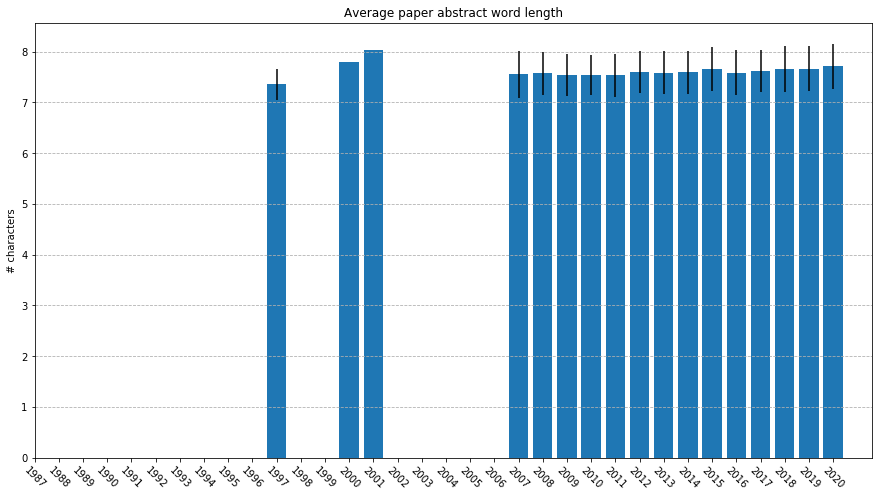

In [639]:
abstract_word_len = np.array([np.mean([np.mean([len(ww) for ww in vv['abstract'].replace('\n', ' ').split(' ') if len(ww) > 3]) for vv in conf_data[kk] if vv['abstract'] is not None and vv['abstract'] != '']) for kk in sorted(conf_data.keys())])
abstract_word_len_std = np.array([np.std([np.mean([len(ww) for ww in vv['abstract'].replace('\n', ' ').split(' ') if len(ww) > 3]) for vv in conf_data[kk] if vv['abstract'] is not None and vv['abstract'] != '']) for kk in sorted(conf_data.keys())])

plt.bar(np.arange(len(abstract_word_len)), abstract_word_len, yerr=abstract_word_len_std)
# plt.plot(abstract_word_len)
# plt.fill_between(
#     np.arange(len(conf_data)),
#     abstract_word_len - 0.5 * abstract_word_len_std,
#     abstract_word_len + 0.5 * abstract_word_len_std,
#     alpha=0.25)

fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Average paper abstract word length')
plt.ylabel('# characters')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
plt.show()

Paper content:

- average paper word length
- average paper word complexity

Although since the paper content has probably been parsed from a PDF it is possible that these numbers might be a bit off

---

Supplementary material
- total number of papers containing some type of supplementary material (pdf or zip)
- average number of papers containing some type of supplementary material (pdf or zip)

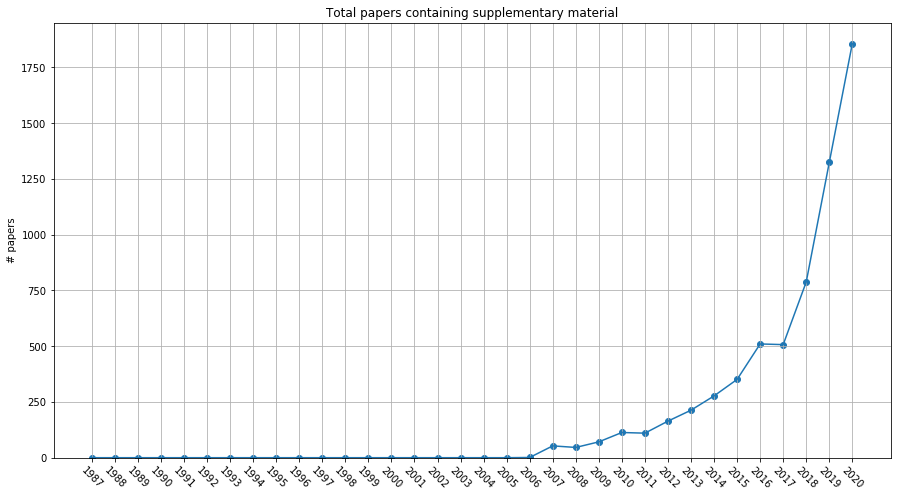

In [640]:
total_supplemental = [np.sum([vv['has_supplement'] for vv in conf_data[kk]]) for kk in sorted(conf_data.keys())]
plt.scatter(np.arange(len(total_supplemental)), total_supplemental)
plt.plot(total_supplemental)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Total papers containing supplementary material')
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid()
plt.show()

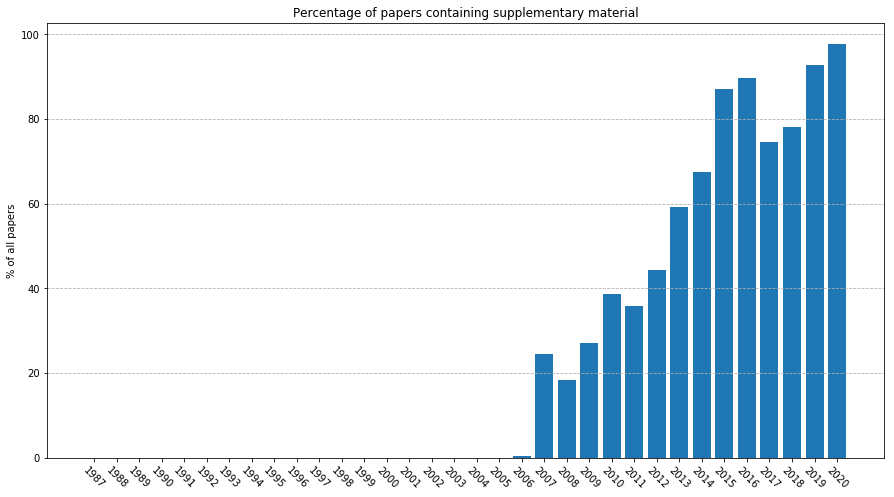

In [641]:
percent_supplemental = [np.mean([vv['has_supplement'] for vv in conf_data[kk]]) * 100 for kk in sorted(conf_data.keys())]
# plt.plot(percent_supplemental)
plt.bar(np.arange(len(percent_supplemental)), percent_supplemental)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Percentage of papers containing supplementary material')
plt.ylabel('% of all papers')
plt.ylim(0)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.grid(linestyle='--', axis='y')
plt.show()

---

## Correlation analysis
[WARNING!] correlation != causation

---

## Trends analysis

- average number of papers published within author's first 5 years (aimed at estimating PhD student "productivity")
- average number of __first author__ papers published within author's first 5 years, excluding single-author papers (aimed at estimating PhD student "productivity")
- average number of __last author__ papers published within author's first 5 years (probably not their first time publishing)


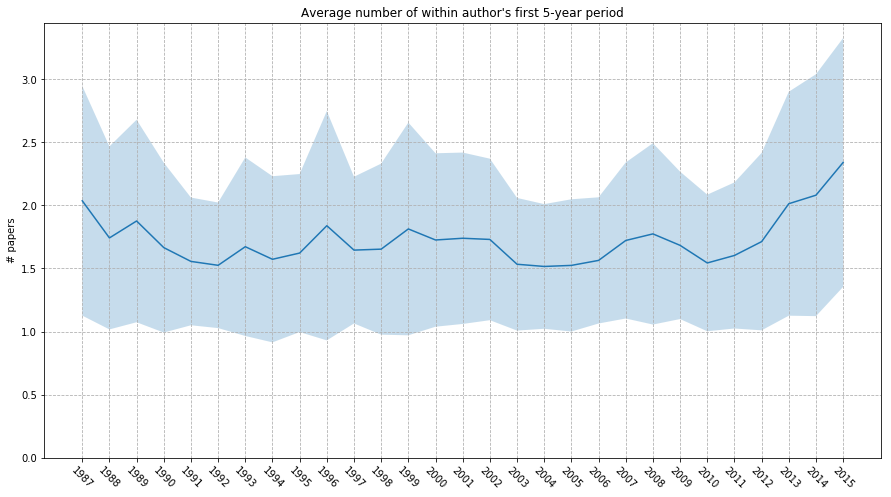

In [642]:
phd_productivity = np.array([np.mean([len(aa) for aa in yy]) for yy in phd_start_year.values()])[:-5]
phd_productivity_std = np.array([np.std([len(aa) for aa in yy]) for yy in phd_start_year.values()])[:-5]
plt.plot(phd_productivity)
plt.fill_between(
    np.arange(len(phd_productivity1)),
    phd_productivity - 0.5 * phd_productivity_std,
    phd_productivity + 0.5 * phd_productivity_std,
    alpha=0.25)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title("Average number of within author's first 5-year period")
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(phd_start_year) - 5), list(phd_start_year.keys())[:-5], rotation=-45)
plt.grid(linestyle='--')
plt.show()

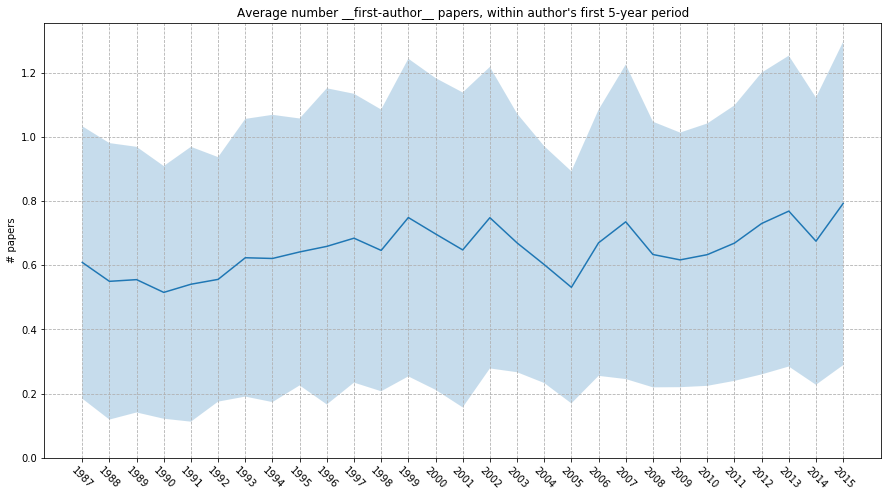

In [643]:
phd_first_author = np.array([np.mean([sum([pp[1] > 1 and pp[0] == 1 for pp in aa]) for aa in yy]) for yy in phd_start_year.values()])[:-5]
phd_first_author_std = np.array([np.std([sum([pp[1] > 1 and pp[0] == 1 for pp in aa]) for aa in yy]) for yy in phd_start_year.values()])[:-5]
plt.plot(phd_first_author)
plt.fill_between(
    np.arange(len(phd_first_author)),
    phd_first_author - 0.5 * phd_first_author_std,
    phd_first_author + 0.5 * phd_first_author_std,
    alpha=0.25)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title("Average number __first-author__ papers, within author's first 5-year period")
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(phd_start_year) - 5), list(phd_start_year.keys())[:-5], rotation=-45)
plt.grid(linestyle='--')
plt.show()

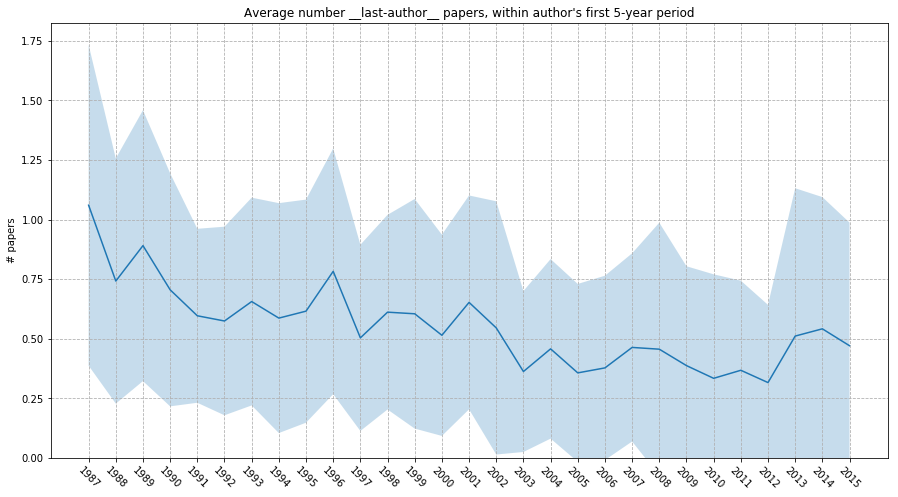

In [644]:
phd_first_author = np.array([np.mean([sum([pp[0] == pp[1]  for pp in aa]) for aa in yy]) for yy in phd_start_year.values()])[:-5]
phd_first_author_std = np.array([np.std([sum([pp[0] == pp[1]  for pp in aa]) for aa in yy]) for yy in phd_start_year.values()])[:-5]

plt.plot(phd_first_author)
plt.fill_between(
    np.arange(len(phd_first_author)),
    phd_first_author - 0.5 * phd_first_author_std,
    phd_first_author + 0.5 * phd_first_author_std,
    alpha=0.25)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title("Average number __last-author__ papers, within author's first 5-year period")
plt.ylabel('# papers')
plt.ylim(0)
plt.xticks(np.arange(len(phd_start_year) - 5), list(phd_start_year.keys())[:-5], rotation=-45)
plt.grid(linestyle='--')
plt.show()

Institution and Author productivity:


- Most popular word / phrase - try different n-grams

- Institution with most accepted papers - top X and show their ratios as area proportions - show in legend by color

- Author with most accepted papers - same as institutions - conference Gini index - total amount of papers per author

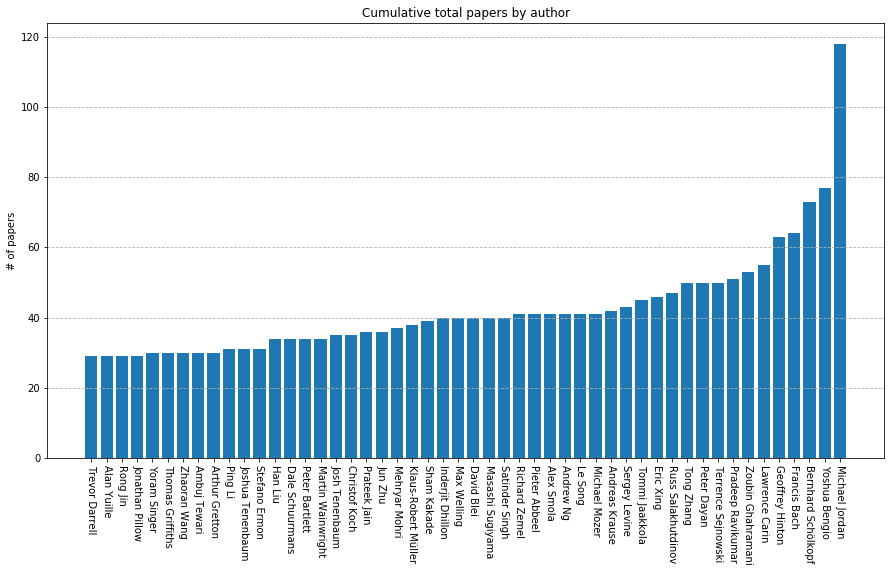

In [645]:
n_papers = [list(vv.values())[0] for vv in total_authors_sorted][-50:]
n_authors = [list(vv.keys())[0] for vv in total_authors_sorted][-50:]

plt.bar(np.arange(len(n_papers)), n_papers)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Cumulative total papers by author')
plt.ylabel('# of papers')
plt.ylim(0)
plt.xticks(np.arange(len(n_authors)), n_authors, rotation=-90)
plt.grid(linestyle='--', axis='y')
plt.show()

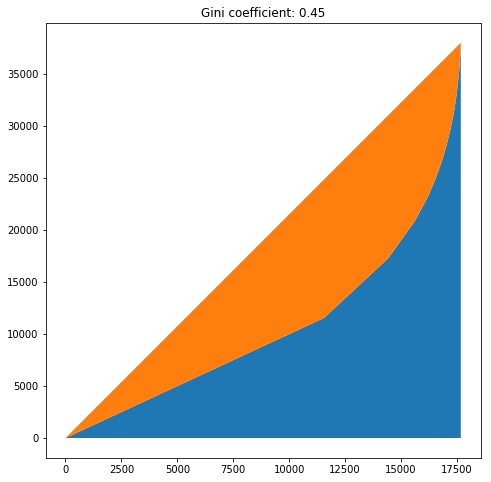

In [646]:
gg = [list(vv.values())[0] for vv in total_authors_sorted]
share_real = np.cumsum(gg)
share_ideal = np.cumsum(np.ones_like(share_real) * share_real[-1] / len(share_real))
share_diff = np.sum(share_ideal - share_real)
gini_coef = share_diff / np.sum(share_ideal)
plt.fill_between(np.arange(len(total_authors_sorted)), 0, share_real)
plt.fill_between(np.arange(len(total_authors_sorted)), share_real, share_ideal)
# plt.axis('')
plt.title("Gini coefficient: {}".format(gini_coef.round(2)))
plt.gca().set_aspect(1/(share_ideal[-1]/len(share_ideal)), adjustable='box')
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.show()

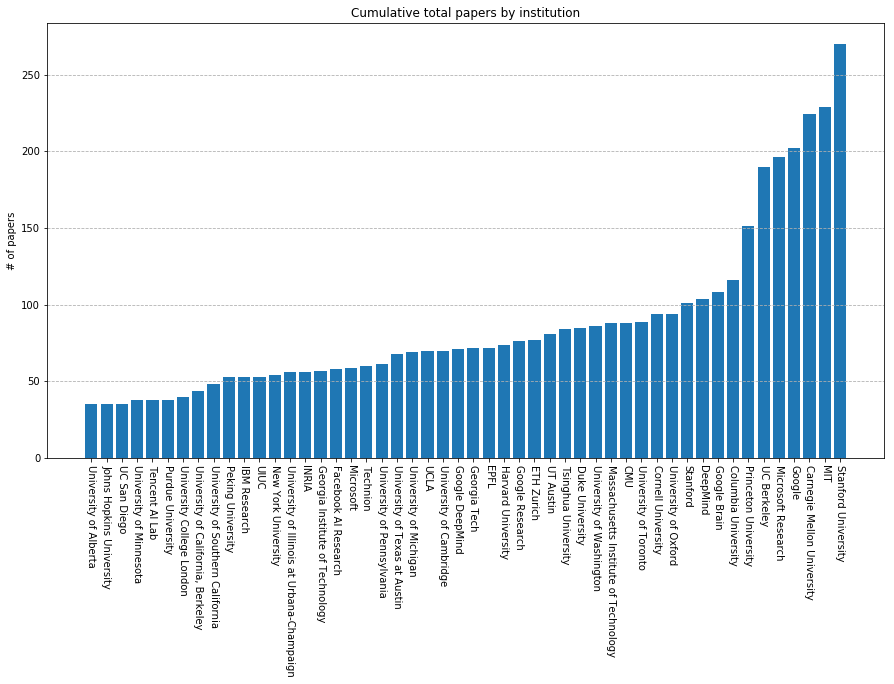

In [647]:
n_papers = [list(vv.values())[0] for vv in total_institutions_sorted][-50:]
n_institutions = [list(vv.keys())[0] for vv in total_institutions_sorted][-50:]

plt.bar(np.arange(len(n_papers)), n_papers)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Cumulative total papers by institution')
plt.ylabel('# of papers')
plt.ylim(0)
plt.xticks(np.arange(len(n_institutions)), n_institutions, rotation=-90)
plt.grid(linestyle='--', axis='y')
plt.show()

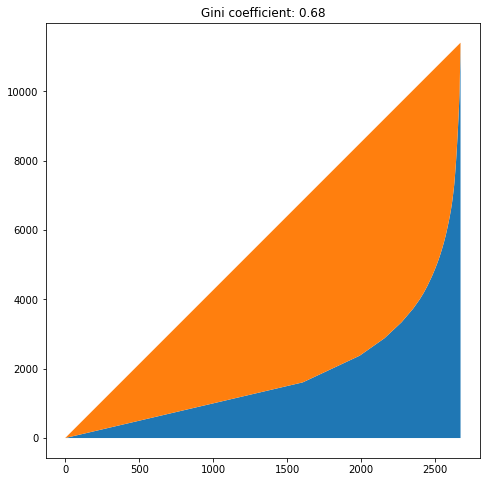

In [648]:
gg = [list(vv.values())[0] for vv in total_institutions_sorted]
share_real = np.cumsum(gg)
share_ideal = np.cumsum(np.ones_like(share_real) * share_real[-1] / len(share_real))
share_diff = np.sum(share_ideal - share_real)
gini_coef = share_diff / np.sum(share_ideal)
plt.fill_between(np.arange(len(total_institutions_sorted)), 0, share_real)
plt.fill_between(np.arange(len(total_institutions_sorted)), share_real, share_ideal)
plt.title("Gini coefficient: {}".format(gini_coef.round(2)))
plt.gca().set_aspect(1/(share_ideal[-1]/len(share_ideal)), adjustable='box')
fig = plt.gcf()
fig.set_size_inches(8, 8)
# http://kimberlyfessel.com/mathematics/applications/gini-use-cases/
# 

## Inclusivity Data

- Ratio of author sex over the years

Although this is an important indicator of diversity, such author information is not available from the NeurIPS paper website. It is possible to get a very rough estimate based on the author's given name by comparing it to a name database of mostly "western" names.

Similarly to the GDP results, these ones should be taken with a grain of salt, as some of the given names which are abbreviated, ambiguous or not in the database, have been classified as 'unknown'.

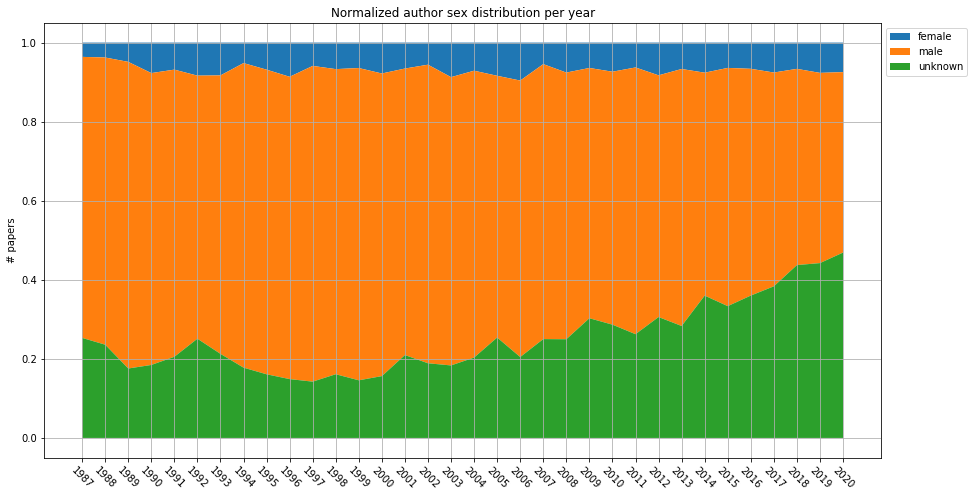

In [649]:
n_authors = np.array([len(ss) for ss in year_stats['unique_authors_info']])
n_female = np.array([np.sum(['female' in vv['gender'] for vv in ss.values()]) for ss in year_stats['unique_authors_info']])
n_female = n_female / n_authors
n_male = np.array([np.sum([vv['gender'] == 'male' or vv['gender'] == 'mostly_male' for vv in ss.values()]) for ss in year_stats['unique_authors_info']])
n_male = n_male / n_authors
n_unknown = np.array([np.sum(['male' not in vv['gender'] for vv in ss.values()]) for ss in year_stats['unique_authors_info']])
n_unknown = n_unknown / n_authors

n_years = np.arange(len(year_stats['unique_authors_info']))
plt.fill_between(n_years, n_unknown + n_male, n_unknown + n_male + n_female, label='female')
plt.fill_between(n_years, n_unknown, n_unknown + n_male, label='male')
plt.fill_between(n_years, 0, n_unknown, label='unknown')

fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Normalized author sex distribution per year')
plt.ylabel('# papers')
plt.ylim(-0.05)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.legend(ncol=1, loc='upper left', bbox_to_anchor=(1, 0., 1, 1))
plt.grid()
plt.show()

- The sex of each paper's first author

Not considering equal contributions, as there is no such information. If one autor had N first-author papers in one year, this author's sex is counted N times.

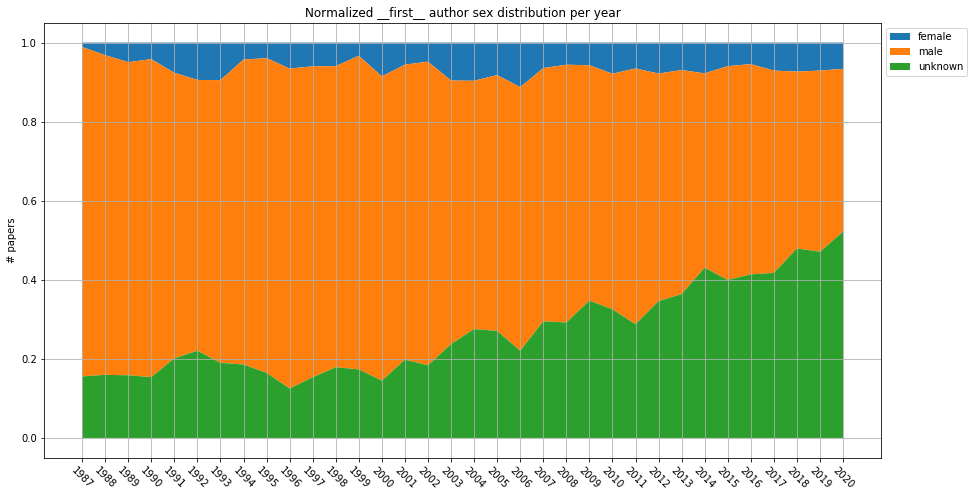

In [650]:
# same as n_accepted
n_accepted = np.array([np.sum([np.sum([pp[0] == 1 for pp in vv['n_papers']]) for vv in ss.values()]) for ss in year_stats['unique_authors_info']])

n_first_female = np.array([np.sum([np.sum([pp[0] == 1 for pp in vv['n_papers']]) for vv in ss.values() if 'female' in vv['gender']]) for ss in year_stats['unique_authors_info']])
n_first_female = n_first_female / n_accepted

n_first_male = np.array([np.sum([np.sum([pp[0] == 1 for pp in vv['n_papers']]) for vv in ss.values() if (vv['gender'] == 'male' or vv['gender'] == 'mostly_male')]) for ss in year_stats['unique_authors_info']])
n_first_male = n_first_male / n_accepted

n_first_unknown = np.array([np.sum([np.sum([pp[0] == 1 for pp in vv['n_papers']]) for vv in ss.values() if 'male' not in vv['gender']]) for ss in year_stats['unique_authors_info']])
n_first_unknown = n_first_unknown / n_accepted

n_years = np.arange(len(year_stats['unique_authors_info']))
plt.fill_between(n_years, n_first_unknown + n_first_male, n_first_unknown + n_first_male + n_first_female, label='female')
plt.fill_between(n_years, n_first_unknown, n_first_unknown + n_first_male, label='male')
plt.fill_between(n_years, 0, n_first_unknown, label='unknown')

fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Normalized __first__ author sex distribution per year')
plt.ylabel('# papers')
plt.ylim(-0.05)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.legend(ncol=1, loc='upper left', bbox_to_anchor=(1, 0., 1, 1))
plt.grid()
plt.show()

- Last author sex

This is usually the group leader or the supervisor

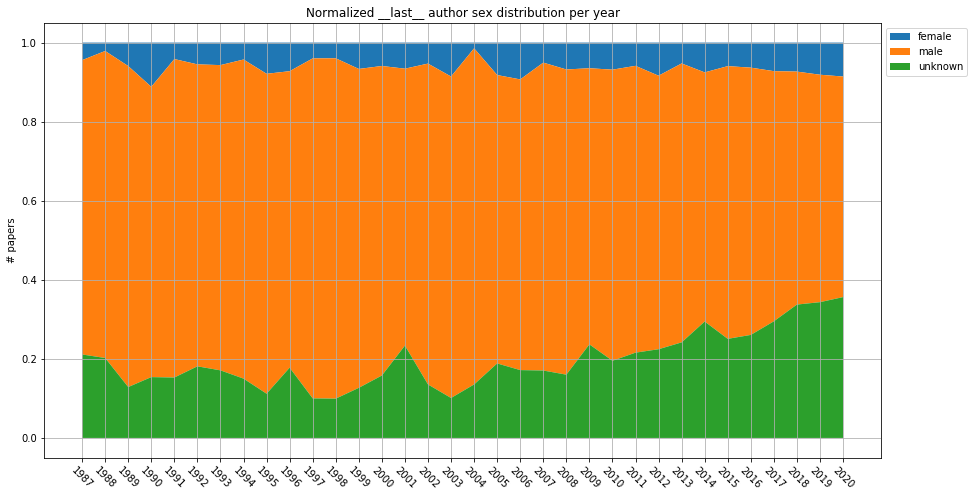

In [651]:
# same as n_accepted
n_accepted = np.array([np.sum([np.sum([pp[0] == pp[1] for pp in vv['n_papers']]) for vv in ss.values()]) for ss in year_stats['unique_authors_info']])

n_first_female = np.array([np.sum([np.sum([pp[0] == pp[1] for pp in vv['n_papers']]) for vv in ss.values() if 'female' in vv['gender']]) for ss in year_stats['unique_authors_info']])
n_first_female = n_first_female / n_accepted

n_first_male = np.array([np.sum([np.sum([pp[0] == pp[1] for pp in vv['n_papers']]) for vv in ss.values() if (vv['gender'] == 'male' or vv['gender'] == 'mostly_male')]) for ss in year_stats['unique_authors_info']])
n_first_male = n_first_male / n_accepted

n_first_unknown = np.array([np.sum([np.sum([pp[0] == pp[1] for pp in vv['n_papers']]) for vv in ss.values() if 'male' not in vv['gender']]) for ss in year_stats['unique_authors_info']])
n_first_unknown = n_first_unknown / n_accepted

n_years = np.arange(len(year_stats['unique_authors_info']))
plt.fill_between(n_years, n_first_unknown + n_first_male, n_first_unknown + n_first_male + n_first_female, label='female')
plt.fill_between(n_years, n_first_unknown, n_first_unknown + n_first_male, label='male')
plt.fill_between(n_years, 0, n_first_unknown, label='unknown')

fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.title('Normalized __last__ author sex distribution per year')
plt.ylabel('# papers')
plt.ylim(-0.05)
plt.xticks(np.arange(len(conf_data)), sorted(conf_data.keys()), rotation=-45)
plt.legend(ncol=1, loc='upper left', bbox_to_anchor=(1, 0., 1, 1))
plt.grid()
plt.show()

- Country's GDP vs number of papers

This is a very rough approximate as country data was not given, and I tried to obtain country data from unstructured Institution names. This procedure consists of checking Location identifier on Wikipedia page of a given institution name. A better option was Google's answer box when searching "INSTITUTION_NAME country name" however, I was unable to access this information, and SERPAPI Google's API for scraping is not free.

Regarding GDP info, I downloaded the spreadsheet file from https://databank.worldbank.org/data/download/GDP.xls and parsed the data for the exctracted countries for 2019.

As expected we can see a slight positive correlation between the country's GDP and the paper output its institutions produced. To quantify the correlation, I calculated the Pearson's correlation coefficient $\rho = 0.83$ with the significance $p=4.75\times10^{-10}$. 

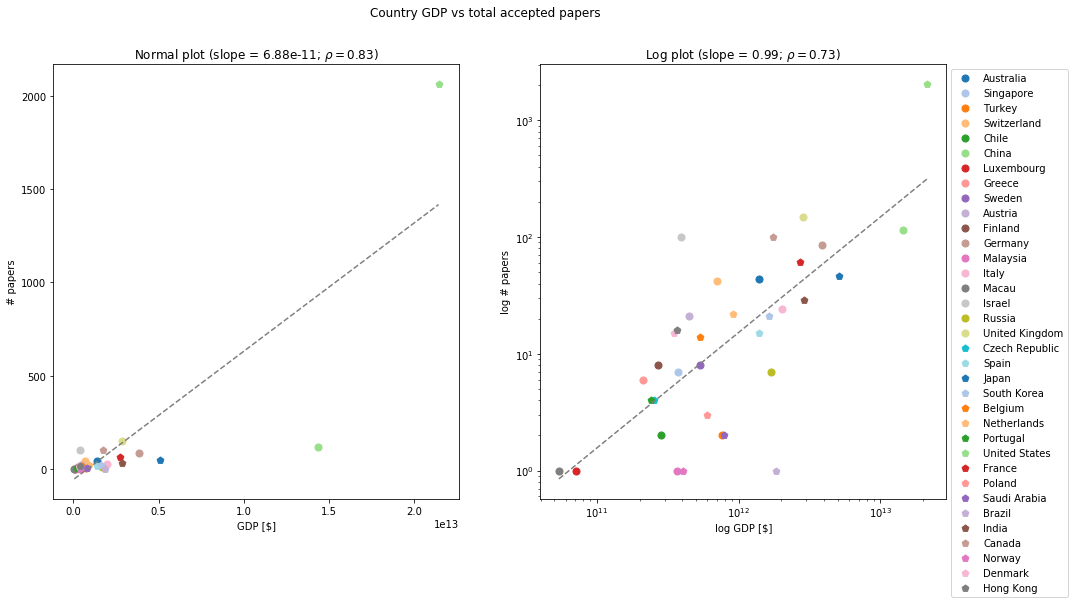

In [652]:
with open('data/country_papers.pkl', 'rb') as handle:
    country_papers = pickle.load(handle)
with open('data/country_gdp.pkl', 'rb') as handle:
    country_gdp = pickle.load(handle)
    
data_gdp = []
data_paper = []

# Plot datapoints
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
NUM_COLORS = len(country_papers)
cm = plt.get_cmap('tab20')
ax[0].set_prop_cycle('color', [cm(i % 20) for i in range(NUM_COLORS)])
ax[1].set_prop_cycle('color', [cm(i % 20) for i in range(NUM_COLORS)])
for i, c_names in enumerate(country_papers.keys()):
    if c_names in country_gdp.keys():
        data_gdp.append(country_gdp[c_names])
        data_paper.append(country_papers[c_names])
        ax[0].scatter(country_gdp[c_names], country_papers[c_names], s=50, label=c_names, marker='o' if i<20 else 'p')
        ax[1].scatter(country_gdp[c_names], country_papers[c_names], s=50, label=c_names, marker='o' if i<20 else 'p')

# Calculate the pearson's correlation coefficient
corr, pval = stats.pearsonr(data_gdp, data_paper)
logcorr, logpval = stats.pearsonr(np.log(data_gdp), np.log(data_paper))

# Fit a line
x = np.linspace(min(data_gdp), max(data_gdp), 100)
res = stats.linregress(data_gdp, data_paper)
ax[0].plot(x, res.intercept + res.slope * x, 'k--', color="0.5")

logres = stats.linregress(np.log(data_gdp), np.log(data_paper))
ax[1].plot(x, np.exp(logres.intercept + logres.slope * np.log(x)), 'k--', color="0.5")

# Plot
fig.suptitle('Country GDP vs total accepted papers')
ax[0].set_title(r'Normal plot (slope = {:.2e}; $\rho = {}$)'.format(res.slope, corr.round(2)))
ax[0].set_xlabel('GDP [$]')
ax[0].set_ylabel('# papers')
ax[1].set_title(r'Log plot (slope = {}; $\rho = {}$)'.format(logres.slope.round(2), logcorr.round(2)))
ax[1].set_xlabel('log GDP [$]')
ax[1].set_ylabel('log # papers')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend(ncol=1, loc='upper left', bbox_to_anchor=(1, 0., 1, 1))
plt.show()